<a href="https://colab.research.google.com/github/osvacerna/PredictionCyberSickness/blob/main/CyberSickness_Prediction_With_OpticalFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerias

In [1]:
!pip3 install opencv-python
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [2]:
import cv2 as cv
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from skimage import io
from google.colab.patches import cv2_imshow

Todos las imagenes y videos empleados se encuentran en el siguiente Drive:

https://drive.google.com/drive/folders/1wmrW-XziikbgSvqLYvZRZQ-CxEr1hSfc?usp=drive_link

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Generar Patron

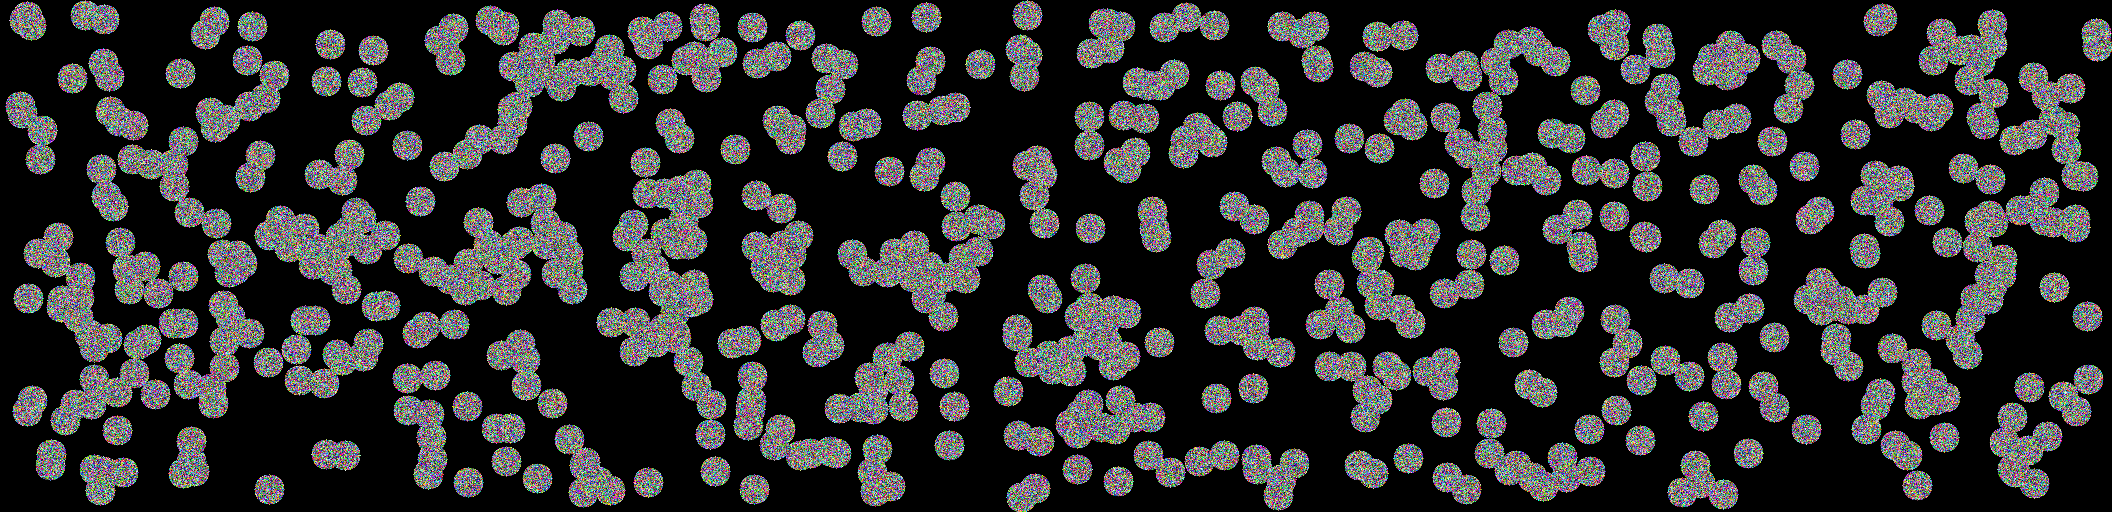

In [3]:
#Aqui Generamos el Patrón de circulos
#Imagenes de tamaño 512x2112 que se pasan como textura en la simulación de Unity

img_dots = np.random.randint(255, size=(512,2112,3))
mask_dots = np.zeros((512,2112,3), np.uint8)

# Se Pueden Especificar la cantidad y el radio de los circulos en la imagen
NumCircles = 750
r = 15

for i in range(NumCircles):
  #Debe haber un espacio en las orillas para evitar circulos incompletos
  x = random.randint(r,2112-r)
  y = random.randint(r,512-r)
  cv.circle(mask_dots,(x,y),r,(255,255,255),-1)

#Empleamos una mascara para obtener el patrón con fondo de Ruido Blanco
#De esta forma se detecta mejor el flujo óptico
for i, row in enumerate(mask_dots):
  for j, val in enumerate(row):
    if (val != np.array([255,255,255])).all():
      img_dots[i][j] = np.array([0,0,0])

#Podemos guardar ambos patrones, con y sin mascara
cv.imwrite('Dots'+str(r)+'_'+str(NumCircles)+'.png', img_dots)
cv.imwrite('DotsMask'+str(r)+'_'+str(NumCircles)+'.png', mask_dots)

cv2_imshow(img_dots)

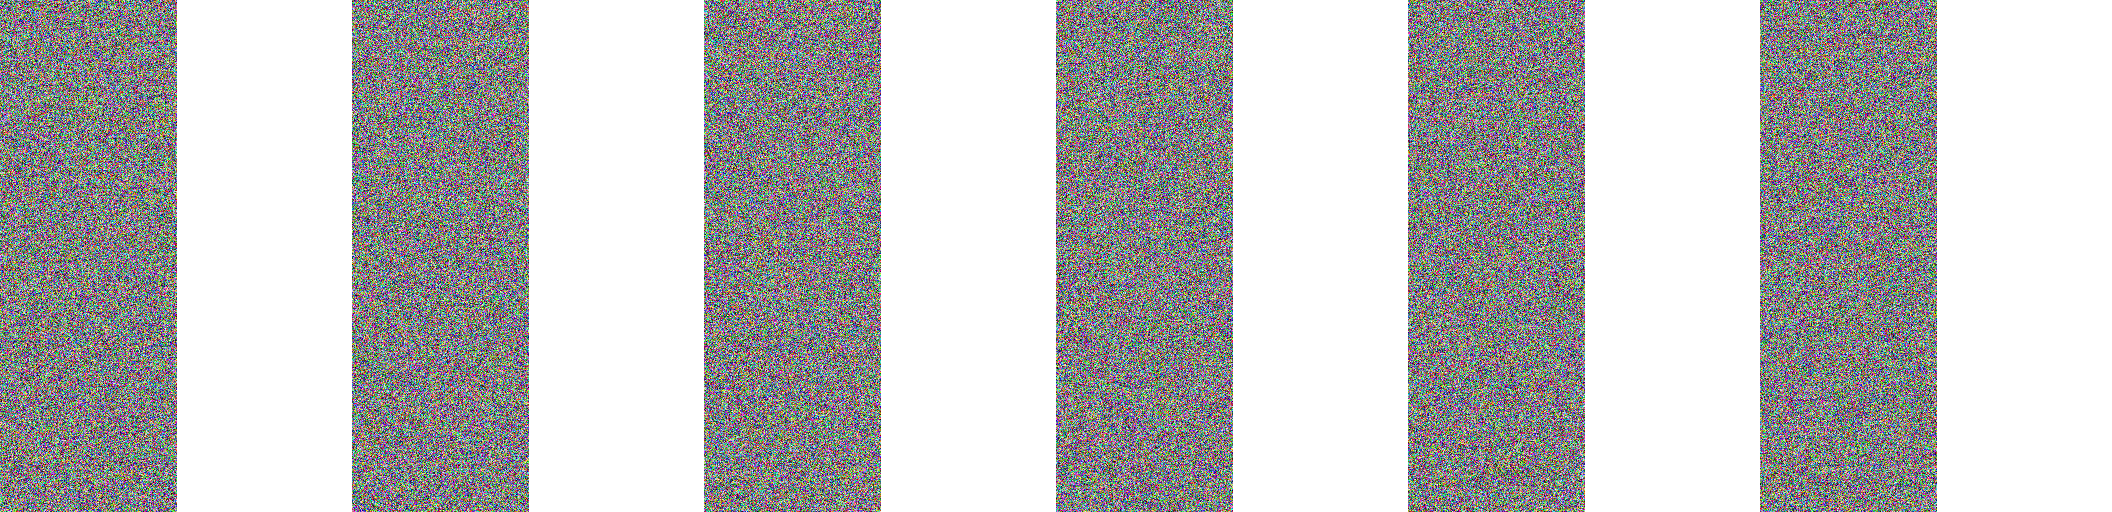

In [ ]:
#Aqui Generamos el Patrón de Lineas Blancas y Negras
#Imagenes de tamaño 512x2112 que se pasan como textura en la simulación de Unity

n = 12 # Doble de Lineas deseadas (12 dará un total de 6 lineas negras)

h = 512; w = 2112
img_lines = np.random.randint(255, size=(h,w,3))
mask_lines = 255*np.ones((h,w,3), np.uint8)

m = int(w/n)
for i in range(n):
  cv.rectangle(mask_lines,(2*m*i,0),(m+2*m*i,h),(0,0,0),-1)

# Empleamos el mismo método de máscara que antes
for i, row in enumerate(mask_lines):
  for j, val in enumerate(row):
    if (val != np.array([0,0,0])).all():
      img_lines[i][j] = np.array([255,255,255])

cv.imwrite('Lines'+str(int(n/2))+'.png', img_lines)
cv.imwrite('LinesMask'+str(int(n/2))+'.png', mask_lines)

cv2_imshow(img_lines)

In [ ]:
#Aquí buscamos guardar el resultado de todos nuestros Flujos Ópticos
#Se espera ya contar con los videos del Drum Giratorio

# Todos los posibles combinaciones para el patrón de puntos, con formato:
# D (Dots) r (radio) n (Numero de puntos/10) _v (Velocidad a la que gira el Drum)
comb = ["D1025_15","D1025_30","D1025_60","D1025_90",
       "D1075_15","D1075_30","D1075_60","D1075_90",
       "D1525_15","D1525_30","D1525_60","D1525_90",
       "D1575_15","D1575_30","D1575_60","D1575_90",]

#Para cada frame de cada video vamos a obtener el Flujo Optico (mapa vectorial)
for c in tqdm(comb):
  cap = cv.VideoCapture(cv.samples.findFile(c+'.mp4'))
  ret, frame1 = cap.read()
  #Se requiere pasar a escala de grises los frames
  frame1 = cv.resize(frame1, (320, 180))
  prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
  aux = 0
  while(1):
    ret, frame2 = cap.read()
    if not ret:
      print('No frames grabbed!')
      break
    frame2 = cv.resize(frame2, (320, 180))
    next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    #Aqui obtenemos el Flujo Optico, se usasn parametros particulares
    flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #Guardamos los arreglos en archivos de texto
    flow = flow.flatten()
    np.savetxt('/content/drive/MyDrive/gen/'+c+'/'+str(aux)+'.txt', flow)
    prvs = next; aux+=1

100%|██████████| 16/16 [17:09<00:00, 64.33s/it]


## Frecuencia espacial

In [7]:
#Función que calcula el Power Spectral Density de una fila de una imágen
def PSD(fila_interes):
  fft_fila = fft(fila_interes)
  n = len(fila_interes)
  frecuencia = np.fft.fftfreq(n)
  psd = (np.abs(fft_fila)**2)/n**2
  psd[1:-1] = 2*psd[1:-1]

  return frecuencia, psd

#Con esta función mostramos visualmente el Power Spectral Density y se compara
#Con una versión escalada de la misma imágen
def Plot_PSD(imagen):
  imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
  imagen_v2 = cv.resize(imagen, (320, 180))

  # Seleccionar la fila de interés (por ejemplo, la fila 100)
  fila_interes = imagen[100, :]
  n = len(fila_interes)

  fila_interes_v2 = imagen_v2[100, :]
  n_v2 = len(fila_interes_v2)

  # Calcular la densidad espectral de potencia (PSD)
  frecuencia, psd = PSD(fila_interes)

  frecuencia_v2, psd_v2 = PSD(fila_interes_v2)

  fig, ax = plt.subplots(2, 2, figsize=(10, 5))
  ax[0][0].plot(fila_interes, color='black')
  ax[0][0].set_title('Señal de una fila en la imagen')
  ax[0][0].set_xlabel('Índice de píxel')
  ax[0][0].set_ylabel('Intensidad (0-255)')
  ax[0][0].grid(True)
  #La señal es simetrica, por eso tomamos la mitad
  ax[0][1].plot(frecuencia[1:n//2], psd[1:n//2])
  ax[0][1].set_title('Power Spectral Density (PSD)')
  ax[0][1].set_xlabel('Frecuencia')
  ax[0][1].set_ylabel('Densidad de potencia')
  ax[0][1].grid(True)
  ax[1][0].plot(fila_interes_v2, color='black')
  ax[1][0].set_title('Señal de una fila en la imagen escalada')
  ax[1][0].set_xlabel('Índice de píxel')
  ax[1][0].set_ylabel('Intensidad (0-255)')
  ax[1][0].grid(True)
  ax[1][1].plot(frecuencia_v2[1:n_v2//2], psd_v2[1:n_v2//2])
  ax[1][1].set_title('Power Spectral Density (PSD)')
  ax[1][1].set_xlabel('Frecuencia')
  ax[1][1].set_ylabel('Densidad de potencia')
  ax[1][1].grid(True)

  plt.tight_layout()
  plt.show()

  # Encontrar la frecuencia donde el PSD es máximo
  # (La frecuencia espacial de la imagen)
  indice_max_psd = np.argmax(psd[1:-1])
  frecuencia_maxima = frecuencia[indice_max_psd]

  indice_max_psd_v2 = np.argmax(psd_v2[1:-1]) # No se considera el primer y utlimo valor
  frecuencia_maxima_v2 = frecuencia_v2[indice_max_psd_v2]

  return print('Frecuencia espacial de la fila 100 de la imagen:', frecuencia_maxima,
               '\nFrecuencia espacial de la fila 100 de la imagen escalada:', frecuencia_maxima_v2)

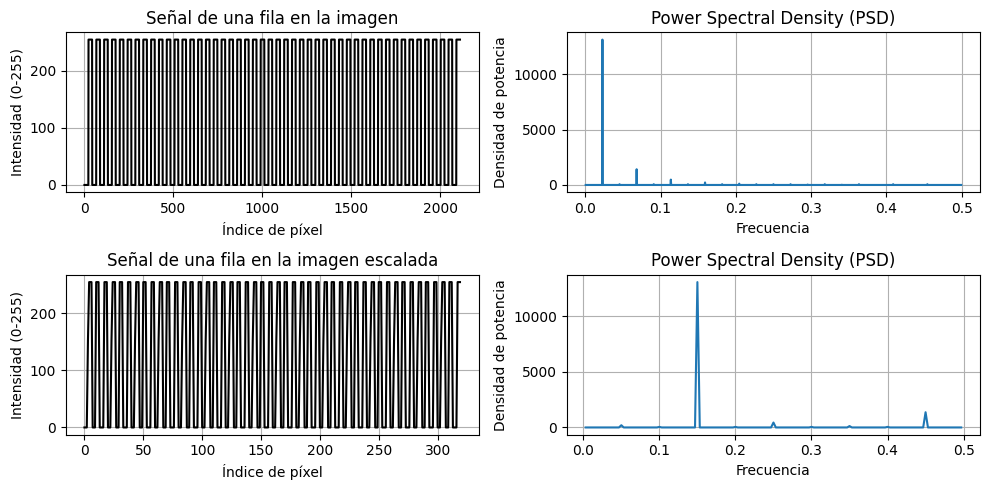

Frecuencia espacial de la fila 100 de la imagen: 0.02225378787878788 
Frecuencia espacial de la fila 100 de la imagen escalada: 0.146875


In [8]:
# Cargar la imagen
imagen = cv.imread('Lines48.png')
Plot_PSD(imagen)

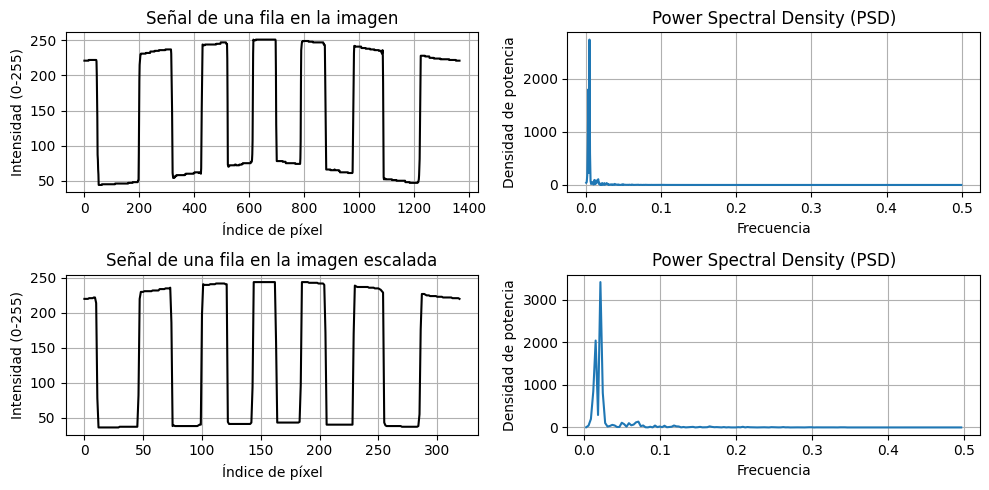

Frecuencia espacial de la fila 100 de la imagen: 0.004392386530014641 
Frecuencia espacial de la fila 100 de la imagen escalada: 0.018750000000000003


In [10]:
#Los patrones vistos desde el simulador son videos de 1 frame
cap = cv.VideoCapture(cv.samples.findFile('24L.mp4'))
ret, imagen = cap.read()

Plot_PSD(imagen)

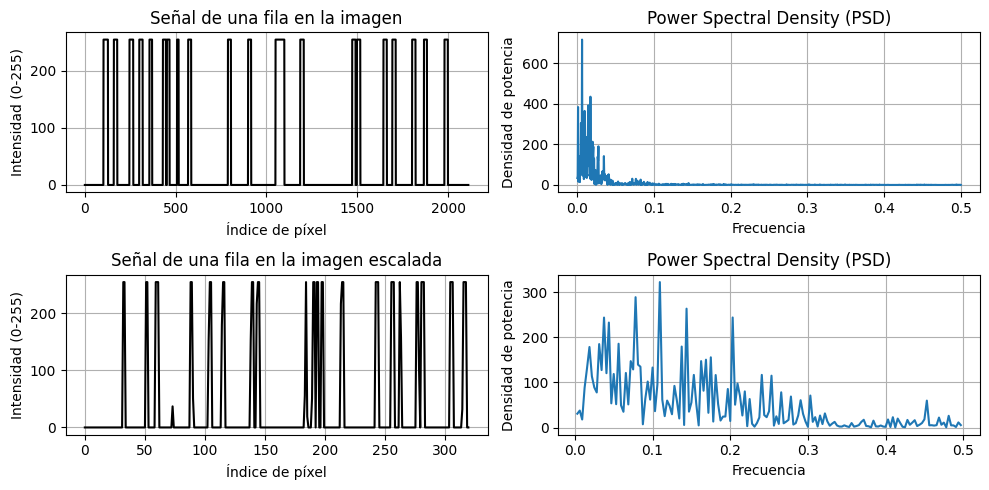

Frecuencia espacial de la fila 100 de la imagen: 0.00615530303030303 
Frecuencia espacial de la fila 100 de la imagen escalada: 0.10625000000000001


In [11]:
# Misma prueba para el patrón de Circulos
imagen = cv.imread('D10_500.png')

Plot_PSD(imagen)

In [13]:
#Se hace unca comparación de la Frecuencia Espacial
#en la imagen original y en el Entorno Virtual (simulación)

aux = ["6L","12L","24L","48L"]
aux2 = ["Lines6","Lines12","Lines24","Lines48"]

print("    Imágen Original       Entorno Virtual")
for i in range(len(aux)):
  cap = cv.VideoCapture(cv.samples.findFile(aux[i]+'.mp4'))
  ret, img1 = cap.read()
  img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)

  img2 = cv.imread(aux2[i]+'.png')
  img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
  frec_avg1 = 0; frec_avg2 = 0
  for fila1, fila2 in zip(img1, img2):
    frecuencia1, psd1 = PSD(fila1)
    indice1 = np.argmax(psd1[1:-1])
    frec_avg1 += frecuencia1[indice1]

    frecuencia2, psd2 = PSD(fila2)
    indice2 = np.argmax(psd2[1:-1])
    frec_avg2 += frecuencia2[indice2]

  #Se debe tomar el promedio de todas las filas de la imagen
  print(aux[i], frec_avg2/512, frec_avg1/768)

    Fracmento Original       Entorno Virtual
6L 0.0023674242424242395 0.0004880429477794107
12L 0.005208333333333348 0.0009760858955588215
24L 0.010890151515151441 0.0029282576866764276
48L 0.022253787878787765 0.0029282576866764276


In [15]:
#Función que calcula la Velocidad Espacial en el movimiento Yaw
#(Medida propuesta por el paper de So)
def Spatial_Velocity_Yaw(imagen, vel):
  imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
  frec_avg = 0
  for fila in imagen:
    frecuencia, psd = PSD(fila)
    indice = np.argmax(psd[1:-1])
    frec_avg += frecuencia[indice]
  return vel*(frec_avg/imagen.shape[0])

D10_500 = cv.imread('D10_500.png')
Lines6 = cv.imread('Lines6.png')
Lines12 = cv.imread('Lines12.png')
Lines24 = cv.imread('Lines24.png')
Lines48 = cv.imread('Lines48.png')

In [18]:
#Se calculan las velocidades espaciales
#para diferentes patrones a todas las posibles velocidades
vel = [15,30,60,90]

Franjas_6 = []; Franjas_12 = []
Franjas_24 = []; Franjas_48 = []
for i in vel:
  Franjas_6.append(Spatial_Velocity_Yaw(Lines6, i))
  Franjas_12.append(Spatial_Velocity_Yaw(Lines12, i))
  Franjas_24.append(Spatial_Velocity_Yaw(Lines24, i))
  Franjas_48.append(Spatial_Velocity_Yaw(Lines48, i))
Franjas = np.array([np.array(Franjas_6), np.array(Franjas_12),
           np.array(Franjas_24), np.array(Franjas_48)])

In [20]:
#Se presentan las Velocidades Espaciales
vel = [15,30,60,90]
print('     Dots  6Lines 12Lines 24Lines 48Lines')
for i in vel:
  print(i,':', "{:.4f}".format(Spatial_Velocity_Yaw(D10_500, i)),
        "{:.4f}".format(Spatial_Velocity_Yaw(Lines6, i)),
        "{:.4f}".format(Spatial_Velocity_Yaw(Lines12, i)),
        "{:.4f}".format(Spatial_Velocity_Yaw(Lines24, i)),
        "{:.4f}".format(Spatial_Velocity_Yaw(Lines48, i)))

     Dots  6Lines 12Lines 24Lines 48Lines
15 : 0.1134 0.0355 0.0781 0.1634 0.3338
30 : 0.2269 0.0710 0.1563 0.3267 0.6676
60 : 0.4537 0.1420 0.3125 0.6534 1.3352
90 : 0.6806 0.2131 0.4688 0.9801 2.0028


In [21]:
#Mismo procedimiento para todos los patrones de círculos

D5_250 = cv.imread('D5_250.png')
D5_500 = cv.imread('D5_500.png')
D5_750 = cv.imread('D5_750.png')
D10_250 = cv.imread('D10_250.png')
D10_500 = cv.imread('D10_500.png')
D10_750 = cv.imread('D10_750.png')
D15_250 = cv.imread('D15_250.png')
D15_500 = cv.imread('D15_500.png')
D15_750 = cv.imread('D15_750.png')

In [ ]:
Dots5_25 = []; Dots5_50 = []; Dots5_75 = []
Dots10_25 = []; Dots10_50 = []; Dots10_75 = []
Dots15_25 = []; Dots15_50 = []; Dots15_75 = []

for i in vel:
  Dots5_25.append(Spatial_Velocity_Yaw(D5_250, i))
  Dots5_50.append(Spatial_Velocity_Yaw(D5_500, i))
  Dots5_75.append(Spatial_Velocity_Yaw(D5_750, i))
  Dots10_25.append(Spatial_Velocity_Yaw(D10_250, i))
  Dots10_50.append(Spatial_Velocity_Yaw(D10_500, i))
  Dots10_75.append(Spatial_Velocity_Yaw(D10_750, i))
  Dots15_25.append(Spatial_Velocity_Yaw(D15_250, i))
  Dots15_50.append(Spatial_Velocity_Yaw(D15_500, i))
  Dots15_75.append(Spatial_Velocity_Yaw(D15_750, i))

Dots = np.array([np.array(Dots5_25), np.array(Dots5_50), np.array(Dots5_75),
                 np.array(Dots10_25), np.array(Dots10_50), np.array(Dots10_75),
                 np.array(Dots15_25), np.array(Dots15_50), np.array(Dots15_75)])

In [ ]:
#Se presenta la primera mitad de la tabla de resultados
vel = [15,30,60,90]
print('     5_25   5_50   5_75   10_25  10_50')
for i in vel:
  print(i,':', "{:.4f}".format(Spatial_Velocity_Yaw(D5_250, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D5_500, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D5_750, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D10_250, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D10_500, i)))

     5_25   5_50   5_75   10_25  10_50
15 : 0.1888 0.1993 0.2181 0.1282 0.1113
30 : 0.3775 0.3986 0.4361 0.2563 0.2227
60 : 0.7550 0.7971 0.8722 0.5126 0.4453
90 : 1.1325 1.1957 1.3084 0.7690 0.6680


In [ ]:
#Se presenta la segunda mitad
vel = [15,30,60,90]
print('     10_75  15_25  15_50  15_75')
for i in vel:
  print(i,':', "{:.4f}".format(Spatial_Velocity_Yaw(D10_750, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D15_250, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D15_500, i)),
              "{:.4f}".format(Spatial_Velocity_Yaw(D15_750, i)))

     10_75  15_25  15_50  15_75
15 : 0.1078 0.1025 0.0821 0.0943
30 : 0.2156 0.2051 0.1641 0.1887
60 : 0.4311 0.4102 0.3283 0.3773
90 : 0.6467 0.6152 0.4924 0.5660


In [ ]:
#Diferencia cuadratica media entre todas las frecuencias espaciales

#Cada Columna es un patrón de Franjas (6,12,24,48)
#Cada Fila es un patrón de Circulos diferente
#(5_25, 5,_50, 5_75, 10_25, 10_50, 10_75, 15_25, 15_50, 15_75)

#Mientras más pequeña la diferencia entre las frecuencias espaciales
#esperamos que las predicciones de la red neuronal sean más similares entre dichos patrones
for D in Dots:
  for F in Franjas:
    print(np.mean((D - F) ** 2), end = ' ')
  print()

0.33462496656224094 0.17439379007555478 0.009192768455491527 0.2998360506285773 
0.3821863663913912 0.2091683680191626 0.018393702628015075 0.2578896972589317 
0.47487730144961765 0.27904855626181 0.04265239723950533 0.1909054046081065 
0.12231860507071876 0.03567483042336009 0.01764861248194858 0.6026415020123413 
0.0819235734164353 0.015715128080226754 0.038559568761114604 0.7052937755361071 
0.07442949620683607 0.012533865630441855 0.044003935830958185 0.727989401645208 
0.06402115191309961 0.008493661880493183 0.05270001316858483 0.7621580411579856 
0.030882577296377306 0.00022115986332418332 0.09415965635052134 0.9030819747381345 
0.04929482690558999 0.0037407210050535867 0.06789384055728483 0.8172454050749651 


## Entrenamiento sin Imagenes

In [ ]:
#Definición de la red neuronal convolucional
#Come imagenes (frames de videos) y regresa mapas vectoriales (imagenes de dos canales)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (320, 180, 2)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 318, 178, 32)        │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 159, 89, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 157, 87, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 78, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 214656)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      13,738,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,757,347 (52.48 MB)

 Trainable params: 13,757,347 (52.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Etiquetamos todos los frames dependiendo de su velocidad y cantidad de franjas

data = []; labels = []
comb = ["6_15","6_30","6_60","6_90","12_15","12_30","12_60","12_90","24_15","24_30","24_60","24_90","48_15","48_30","48_60","48_90"]
lab = [[1,0,0],[1,0,0],[0,1,0],[1,0,0],
       [1,0,0],[0,1,0],[0,0,1],[0,1,0],
       [0,1,0],[0,0,1],[0,0,1],[0,0,1],
       [1,0,0],[0,1,0],[0,0,1],[0,1,0]]

for c,l in tqdm(zip(comb, lab)):
    for j in range(150):
        data.append(np.loadtxt("drive/MyDrive/gen/"+c+"/"+str(j)+".txt").reshape(320,180,2))
        labels.append(l)
data = np.array(data)
labels = np.array(labels)

16it [03:29, 13.11s/it]


In [ ]:
#Separamos el data set en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42,shuffle=True)

In [ ]:
#Entrenamos
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = 20)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.7591 - loss: 1.2009
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.7943 - loss: 0.7451
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.8155 - loss: 0.4874
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.8306 - loss: 0.4635
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8499 - loss: 0.3417
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8683 - loss: 0.2726
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8755 - loss: 0.2447
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8786 - loss: 0.2173
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8866 - loss: 0.2086
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.8838 - loss: 0.2179
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8748 - loss: 0.2144
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy:

In [ ]:
#Guardamos el modelo
model.save('ModeloSinRuidoBlanco.h5')
model.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 787ms/step - accuracy: 0.8316 - loss: 0.4227


[0.44173464179039, 0.8374999761581421]

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo entrenado
model = load_model('ModeloSinImagenes.h5')

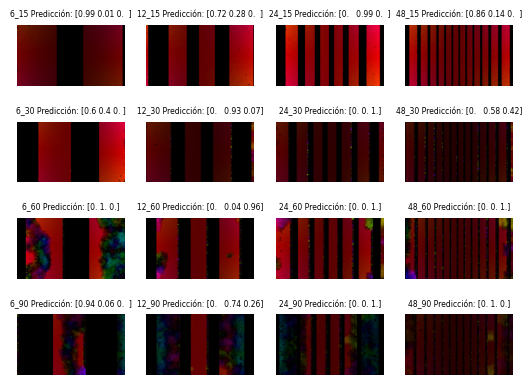

In [ ]:
#Una muestra de los resultados, unicamente de forma ilustrativa
#Las imagenes son en realidad un mapa de vectores interpretado con el formato de color HSV

from matplotlib import pyplot as plt

fig, ax = plt.subplots(4,4)
i = 0
Comb = np.array(comb).reshape((4,4)).transpose()
for i in range(4):
  for k in range(4):
    c = Comb[i][k]
    j = np.random.randint(0,150)
    img = cv.imread("drive/MyDrive/gen/"+c+"/"+str(j)+".png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (320, 180))

    test = np.loadtxt("drive/MyDrive/gen/"+c+"/"+str(j)+".txt")
    test = np.reshape(test, (320, 180, 2))
    test = np.expand_dims(test, axis =0)

    ax[i,k].imshow(img)
    ax[i,k].axis("off")
    ax[i,k].set_title(c + " Predicción: " +
                      str(np.round_(model.predict(test,verbose=False)[0],2)),
                      fontsize=5.5)

In [ ]:
#Función que Toma un vector con el patrón y velocidades que se quieren predecir
#Y regresa las predicciones encontradas por la red neuronal
def Avrg_Predict(Texture):
  Predicts = []
  for it in range(120):
    img = np.loadtxt('drive/MyDrive/gen/'+Texture+'/'+str(it)+'.txt')
    img = np.reshape(img, (320, 180, 2))
    img = np.expand_dims(img, axis =0) #Dimensiones requeridas por la red
    Predicts.append(np.round_(model.predict(img,verbose = False)[0],2))
  Predicts = np.array(Predicts)
  return Predicts, np.mean(Predicts, axis=0)

#Función que imprime resultados
def Print_Predict(Textures):
  P_15, mean_15 = Avrg_Predict(Textures[0])
  P_30, mean_30 = Avrg_Predict(Textures[1])
  P_60, mean_60 = Avrg_Predict(Textures[2])
  P_90, mean_90 = Avrg_Predict(Textures[3])

  print("Predict","Bajo Medio Alto")
  print("12_15", "{:.2f}".format(mean_15[0]), "{:.2f}".format(mean_15[1]), "{:.2f}".format(mean_15[2]))
  print("12_30", "{:.2f}".format(mean_30[0]), "{:.2f}".format(mean_30[1]), "{:.2f}".format(mean_30[2]))
  print("12_60", "{:.2f}".format(mean_60[0]), "{:.2f}".format(mean_60[1]), "{:.2f}".format(mean_60[2]))
  print("12_90", "{:.2f}".format(mean_90[0]), "{:.2f}".format(mean_90[1]), "{:.2f}".format(mean_90[2]))

In [ ]:
#Predicciones del patrón de 24 franjas
Textura_24 = ['24_15','24_30','24_60','24_90']
Print_Predict(Textura_24)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 0.01 0.99 0.00
12_30 0.00 0.00 1.00
12_60 0.00 0.00 1.00
12_90 0.00 0.00 1.00


In [ ]:
Textura_D1 = ['D525_15','D525_30','D525_60','D525_90']
Print_Predict(Textura_D1)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 1.00 0.00 0.00
12_30 1.00 0.00 0.00
12_60 0.51 0.49 0.00
12_90 0.36 0.64 0.00


In [ ]:
Textura_D3 = ['D550_15','D550_30','D550_60','D550_90']
Print_Predict(Textura_D3)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 1.00 0.00 0.00
12_30 0.23 0.77 0.00
12_60 0.00 1.00 0.00
12_90 0.07 0.90 0.03


In [ ]:
Textura_D4 = ['D575_15','D575_30','D575_60','D575_90']
Print_Predict(Textura_D4)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 0.90 0.10 0.00
12_30 0.00 0.99 0.01
12_60 0.00 0.82 0.18
12_90 0.06 0.68 0.26


In [ ]:
Textura_D4 = ['D1025_15','D1025_30','D1025_60','D1025_90']
Print_Predict(Textura_D4)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 1.00 0.00 0.00
12_30 0.57 0.43 0.00
12_60 0.05 0.95 0.00
12_90 0.01 0.99 0.00


In [ ]:
Textura_D5 = ['D1075_15','D1075_30','D1075_60','D1075_90']
Print_Predict(Textura_D5)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 0.47 0.53 0.00
12_30 0.00 0.95 0.04
12_60 0.00 0.29 0.71
12_90 0.00 0.18 0.82


In [ ]:
Textura_D4 = ['D1525_15','D1525_30','D1525_60','D1525_90']
Print_Predict(Textura_D4)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 1.00 0.00 0.00
12_30 0.26 0.74 0.00
12_60 0.00 0.99 0.01
12_90 0.00 0.97 0.03


In [ ]:
Textura_D2 = ['D1550_15','D1550_30','D1550_60','D1550_90']
Print_Predict(Textura_D2)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 0.62 0.38 0.00
12_30 0.00 0.89 0.11
12_60 0.00 0.37 0.63
12_90 0.00 0.44 0.56


In [ ]:
Textura_D4 = ['D1575_15','D1575_30','D1575_60','D1575_90']
Print_Predict(Textura_D4)

<ipython-input-56-c1ae3b3bc0ef>:12: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_15, mean_15 = Avrg_Predict(Textures[0])
<ipython-input-56-c1ae3b3bc0ef>:13: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_30, mean_30 = Avrg_Predict(Textures[1])
<ipython-input-56-c1ae3b3bc0ef>:14: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_60, mean_60 = Avrg_Predict(Textures[2])
<ipython-input-56-c1ae3b3bc0ef>:15: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  P_90, mean_90 = Avrg_Predict(Textures[3])


Predict Bajo Medio Alto
12_15 0.20 0.80 0.00
12_30 0.00 0.59 0.41
12_60 0.00 0.10 0.90
12_90 0.00 0.08 0.92


## Optical Flow

### Imagenes

In [ ]:
import numpy as np
import cv2 as cv
from tqdm import tqdm

vel = ["48Lines_15","48Lines_30","48Lines_60","48Lines_90",
       "6Lines_15","6Lines_30","6Lines_60","6Lines_90"]
comb = ["6_15","6_30","6_60","6_90","12_15","12_30","12_60","12_90",
        "24_15","24_30","24_60","24_90","48_15","48_30","48_60","48_90"]

#Proceso para obtener imagenes de flujo Optico que pasan los vectores a una presentación
#que útiliza el formato de color HSV
for i in tqdm(range(16)):
  cap = cv.VideoCapture(cv.samples.findFile(str(comb[i])+'.mp4'))
  ret, frame1 = cap.read()
  prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[..., 1] = 255
  aux = 0
  while(1):
      ret, frame2 = cap.read()
      if not ret:
          # print('No frames grabbed!')
          break
      next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
      flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
      #Conversión a formato HSV
      mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1])
      hsv[..., 0] = ang*180/np.pi/2
      hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX)
      bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
      cv.imwrite('/content/drive/MyDrive/gen/'+str(comb[i])+'/'+str(aux)+'.png', bgr)
      aux += 1
      prvs = next

  cv.destroyAllWindows()

100%|██████████| 16/16 [1:43:54<00:00, 389.64s/it]


In [ ]:
for j in tqdm(range(16)):
  frames = []
  for i in range(60):
    frames.append(cv.imread('/content/drive/MyDrive/gen/'+str(comb[j])+'/'+str(i)+'.png'))
  filas, columnas, canales = frames[0].shape
  video = cv.VideoWriter('OpFlw_'+str(comb[j])+'.mp4', cv.VideoWriter_fourcc(*'mp4v'), 30, (columnas, filas))
  for frame in frames:
    video.write(frame)
  video.release()

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


### Flechitas

In [ ]:
cap = cv.VideoCapture(cv.samples.findFile(str(comb[0])+'.mp4'))

ret, frame1 = cap.read()
frame1 = cv.resize(frame1, (320, 180))
prvs = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)

hsv = np.zeros_like(frame1)
hsv[..., 1] = 255

ret, frame2 = cap.read()
frame2 = cv.resize(frame2, (320, 180))
next = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)

#Con esta lina se puede obtener el flujo optico en su versión de mapa vectorial
#Este proceso lo realizamos para cada uno de los frames de nuestro video interés en
#la sección del Modelo sin Imagenes
flow = cv.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

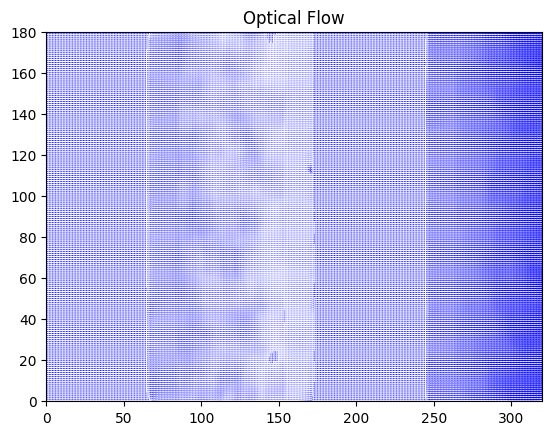

In [ ]:
#Esta es una simple muestra de como se veria una imágen de flujo óptico
#Representada por el mapa vectorial y no por el formato HSV, no es muy visual.

from matplotlib import pyplot as plt

x = range(320)
y = range(180)

u = flow[..., 0]
v = flow[..., 1]

plt.title('Optical Flow')
plt.xlim(0, 320)
plt.ylim(0, 180)

plt.quiver(x,y,u,v,color='b')
plt.show()

## Comparar Frames

In [ ]:
import numpy as np
import cv2 as cv
from tqdm import tqdm
import matplotlib.pyplot as plt
#Usamos la metrica ssim para medir que tan parecidos son los frames entre ellos
from skimage.metrics import structural_similarity as ssim

#Claculamos el flujo óptico de los drums girando al menos 2 veces
#Esto genera videos de diferente duración, pues giran a velocidades diferentes
vel = [15,30,60,90]
frames = [1440,720,180,120]
Dots_ssims = []
for j in range(4):
  Dots_ssim = []
  frame1 = cv.imread("drive/MyDrive/gen/Dots_"+str(vel[j])+"/0.png")
  frame1 = cv.resize(frame1, (320, 180))
  for i in tqdm(range(frames[j]-1)):
    act_frame = cv.imread("drive/MyDrive/gen/Dots_"+str(vel[j])+"/"+str(i)+".png")
    act_frame = cv.resize(act_frame, (320, 180))
    Dots_ssim.append(ssim(frame1, act_frame, data_range=act_frame.max() - act_frame.min(), win_size=3))
  Dots_ssims.append(np.array(Dots_ssim))

100%|██████████| 119/119 [00:59<00:00,  1.99it/s]


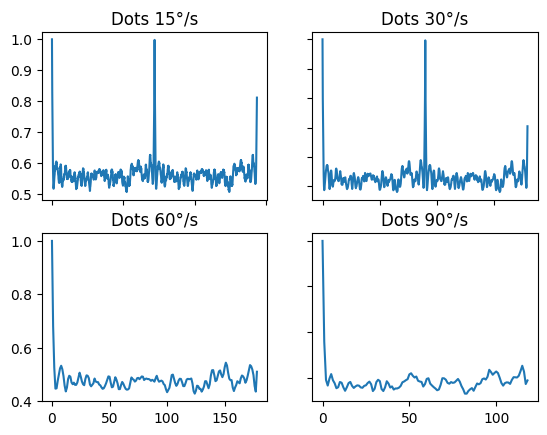

In [ ]:
x0 = np.array(range(frames[0]-1))
x1 = np.array(range(frames[1]-1))
x2 = np.array(range(frames[2]-1))
x3 = np.array(range(frames[3]-1))
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x0, Dots_ssims[0])
axs[0, 1].plot(x1, Dots_ssims[1])
axs[1, 0].plot(x2, Dots_ssims[2])
axs[1, 1].plot(x3, Dots_ssims[3])
axs[0, 0].set_title('Dots 15°/s')
axs[0, 1].set_title('Dots 30°/s')
axs[1, 0].set_title('Dots 60°/s')
axs[1, 1].set_title('Dots 90°/s')
for ax in axs.flat:
    ax.label_outer()

#En el gráfico se compara cada frame con el primero, con el objetivo de ver
#en que momento la información que aporta el video es repetitiva

#Notemos como en el centro hay un pico evidente, pues al completar una vuelta
#el frame es muy similar al del inicio

In [ ]:
Lines6_ssims = []
for j in range(4):
  Lines6_ssim = []
  frame1 = cv.imread("drive/MyDrive/gen/6Lines_"+str(vel[j])+"/0.png")
  frame1 = cv.resize(frame1, (320, 180))
  for i in tqdm(range(frames[j]-1)):
    act_frame = cv.imread("drive/MyDrive/gen/6Lines_"+str(vel[j])+"/"+str(i)+".png")
    act_frame = cv.resize(act_frame, (320, 180))
    Lines6_ssim.append(ssim(frame1, act_frame, data_range=act_frame.max() - act_frame.min(), win_size=3))
  Lines6_ssims.append(np.array(Lines6_ssim))

100%|██████████| 119/119 [00:11<00:00, 10.70it/s]


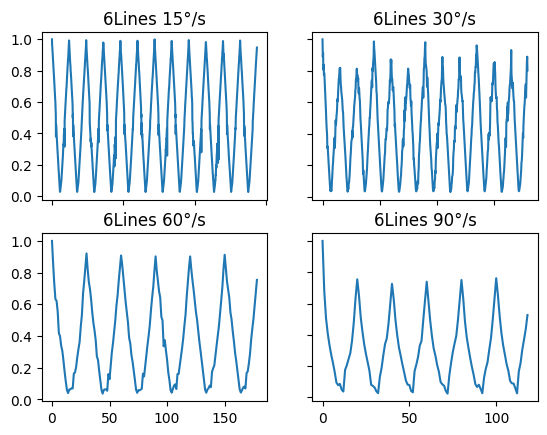

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x0, Lines6_ssims[0])
axs[0, 1].plot(x1, Lines6_ssims[1])
axs[1, 0].plot(x2, Lines6_ssims[2])
axs[1, 1].plot(x3, Lines6_ssims[3])
axs[0, 0].set_title('6Lines 15°/s')
axs[0, 1].set_title('6Lines 30°/s')
axs[1, 0].set_title('6Lines 60°/s')
axs[1, 1].set_title('6Lines 90°/s')
for ax in axs.flat:
    ax.label_outer()

In [ ]:
Lines48_ssims = []
for j in range(4):
  Lines48_ssim = []
  frame1 = cv.imread("drive/MyDrive/gen/48Lines_"+str(vel[j])+"/0.png")
  frame1 = cv.resize(frame1, (320, 180))
  for i in tqdm(range(frames[j]-1)):
    act_frame = cv.imread("drive/MyDrive/gen/48Lines_"+str(vel[j])+"/"+str(i)+".png")
    act_frame = cv.resize(act_frame, (320, 180))
    Lines48_ssim.append(ssim(frame1, act_frame, data_range=act_frame.max() - act_frame.min(), win_size=3))
  Lines48_ssims.append(np.array(Lines48_ssim))

100%|██████████| 119/119 [00:07<00:00, 15.80it/s]


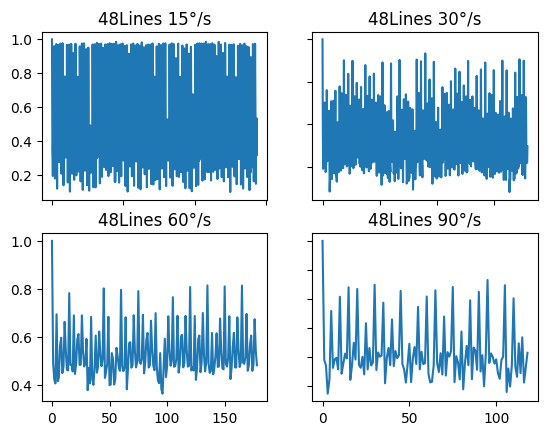

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x0, Lines48_ssims[0])
axs[0, 1].plot(x1, Lines48_ssims[1])
axs[1, 0].plot(x2, Lines48_ssims[2])
axs[1, 1].plot(x3, Lines48_ssims[3])
axs[0, 0].set_title('48Lines 15°/s')
axs[0, 1].set_title('48Lines 30°/s')
axs[1, 0].set_title('48Lines 60°/s')
axs[1, 1].set_title('48Lines 90°/s')
for ax in axs.flat:
    ax.label_outer()